# Cavity flow with Navier-Stokes

The final two steps will both solve the Navier–Stokes equations in two dimensions, but with different boundary conditions.

The momentum equation in vector form for a velocity field v⃗ 

is:

$$ \frac{\partial \overrightarrow{v}}{\partial t} + (\overrightarrow{v} \cdot \nabla ) \overrightarrow{v} = -\frac{1}{\rho}\nabla p + \nu \nabla^2 \overrightarrow{v}$$

This represents three scalar equations, one for each velocity component (u,v,w). But we will solve it in two dimensions, so there will be two scalar equations.

Remember the continuity equation? This is where the Poisson equation for pressure comes in!

Here is the system of differential equations: two equations for the velocity components u,v and one equation for pressure:

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}= -\frac{1}{\rho}\frac{\partial p}{\partial x}  + \nu \left[ \frac{\partial^2 u}{\partial x^2} +\frac{\partial^2 u}{\partial y^2} \right] $$

$$ \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}= -\frac{1}{\rho}\frac{\partial p}{\partial y}  + \nu \left[ \frac{\partial^2 v}{\partial x^2} +\frac{\partial^2 v}{\partial y^2} \right] $$

$$
\frac{\partial^2 p}{\partial x^2} +\frac{\partial^2 p}{\partial y^2} =
-\rho \left[ \frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right]
$$

From the previous steps, we already know how to discretize all these terms. Only the last equation is a little unfamiliar. But with a little patience, it will not be hard!


Our stencils look like this:
First the momentum equation in the u direction
$$
\begin{split}
u_{i,j}^{n+1} = u_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(u_{i,j}^{n}-u_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(u_{i,j}^{n}-u_{i,j-1}^{n}\right) \\
& - \frac{\Delta t}{\rho 2\Delta x} \left(p_{i+1,j}^{n}-p_{i-1,j}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n}\right)\right)
\end{split}
$$
Second the momentum equation in the v direction
$$
\begin{split}
v_{i,j}^{n+1} = v_{i,j}^{n} & - u_{i,j}^{n} \frac{\Delta t}{\Delta x} \left(v_{i,j}^{n}-v_{i-1,j}^{n}\right) - v_{i,j}^{n} \frac{\Delta t}{\Delta y} \left(v_{i,j}^{n}-v_{i,j-1}^{n})\right) \\
& - \frac{\Delta t}{\rho 2\Delta y} \left(p_{i,j+1}^{n}-p_{i,j-1}^{n}\right) \\
& + \nu \left(\frac{\Delta t}{\Delta x^2} \left(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n}\right) + \frac{\Delta t}{\Delta y^2} \left(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n}\right)\right)
\end{split}
$$
Finally the pressure-Poisson equation
$$\begin{split}
p_{i,j}^{n} = & \frac{\left(p_{i+1,j}^{n}+p_{i-1,j}^{n}\right) \Delta y^2 + \left(p_{i,j+1}^{n}+p_{i,j-1}^{n}\right) \Delta x^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& -\frac{\rho\Delta x^2\Delta y^2}{2\left(\Delta x^2+\Delta y^2\right)} \\
& \times \left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x} -2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]
\end{split}
$$

The initial condition is $u,v,p=0$

everywhere, and the boundary conditions are:

$u=1$ at $y=2$ (the "lid");

$u,v=0$ on the other boundaries;

$\frac{\partial p}{\partial y}=0$ at $y=0$;

$p=0$ at $y=2$

$\frac{\partial p}{\partial x}=0$ at $x=0,2$


In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx)) 
b = numpy.zeros((ny, nx))

The pressure Poisson equation that's written above can be hard to write out without typos. The function build_up_b below represents the contents of the square brackets, so that the entirety of the PPE is slightly more manageable.

In [3]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

The function pressure_poisson is also defined to help segregate the different rounds of calculations. Note the presence of the pseudo-time variable nit. This sub-iteration in the Poisson calculation helps ensure a divergence-free field.

In [4]:
def pressure_poisson(p, dx, dy, b):
    pn = numpy.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

In [30]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

In [31]:


u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 100
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)



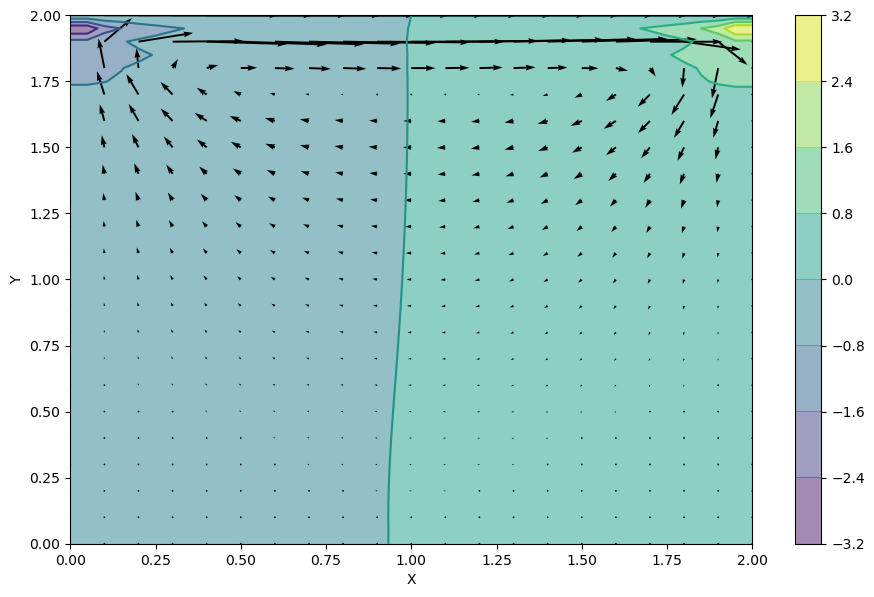

In [32]:


fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
pyplot.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');



In [8]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

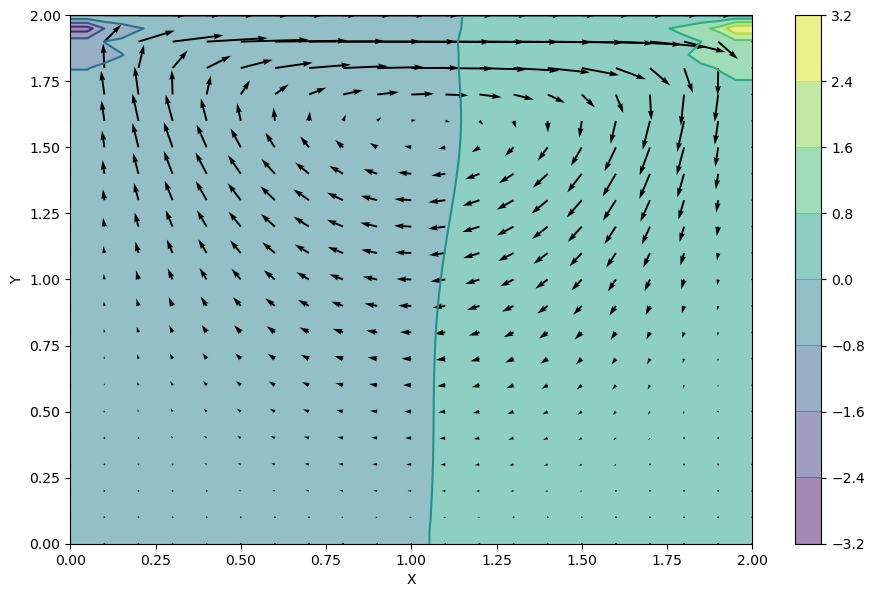

In [9]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

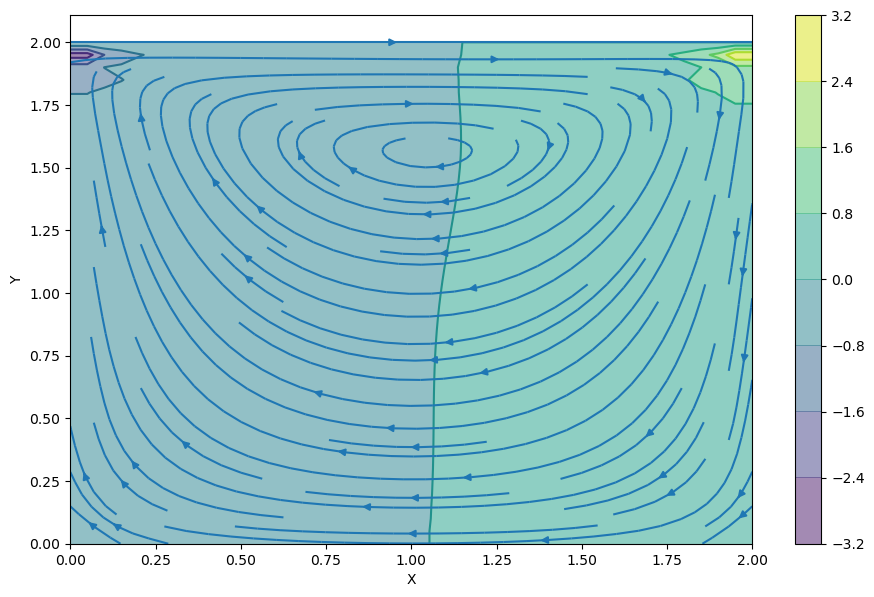

In [10]:


fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');

